# Cepstrum/Liftering

- https://en.wikipedia.org/wiki/Cepstrum
- https://ccrma.stanford.edu/~jos/SpecEnv/Cepstral_Smoothing.html


## Load audio and Libraries

In [1]:
%pylab inline
from IPython.display import Audio
import librosa
plt.rcParams['axes.grid'] = True

Populating the interactive namespace from numpy and matplotlib


In [3]:
x,sr = librosa.load('../data/drumLoop.wav', sr=None)
N = len(x)
n = arange(N)
t = n/sr

Text(0.5, 1.0, 'Time Domain Signal')

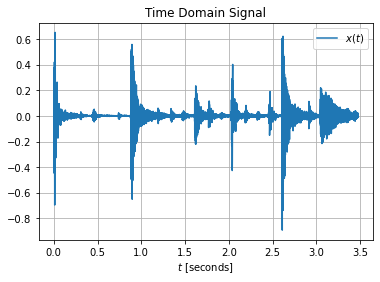

In [9]:
plot(t,x, label='$x(t)$')
xlabel('$t$ [seconds]')
legend()
title('Time Domain Signal')

## Compute Spectrum and Cepstrum
- $X(m)$ shall be the spectrum of $x(n)$, so:
$$ X(m) = \mathscr{F}\{x(n)\}$$

- We will compute the complex cepstrum $C(m)$ via:

$$C(m) = \mathscr{F}^{-1}\{log(X(m)) \} $$

- We will convert back, so compute the complex spectrum $X(m)$ from $C(m)$ via:

$$ X(m) = e^{\mathscr{F}\{ C(m) \} }$$


- We will compute the magnitude cepstrum $C_{mag}(m)$ via:

$$C_{mag}(m) = \mathscr{F}^{-1}\{log(|X(m)|) \} $$


In [5]:
spec = fft.fft(x)
mag_cep = fft.ifft(log(abs(spec)))

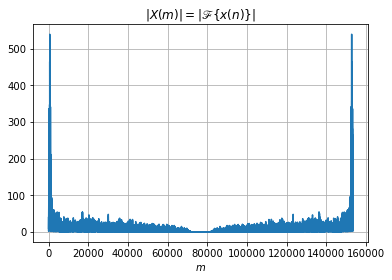

In [64]:
plot(abs(spec))
title('$|X(m)| = |\mathscr{F}\{x(n)\}|$')
xlabel('$m$')
show()

## Low-time lifter for Spectral Smoothing
We 'low time lifter' in the cepstrum, so low pass filter the spectrum with a rectangular window $w(m)$.
We multiply the cepstrum with $w(m)$ to obtain a smooth (low pass filtered) spectrum:
$$ X_s(m) = exp (\mathscr{F} \{ C(m) \cdot w(m) \})$$

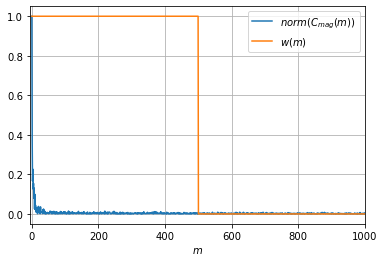

In [68]:
window = zeros(N)
window[0:500] = 1
window[N//2:] = flip(window[0:N//2])
plot(abs(mag_cep)/max(abs(mag_cep)),label='$norm(C_{mag}(m))$')
plot(window, label='$w(m)$')
xlabel('$m$')
xlim([-5,1000])
legend()
show()

In [57]:
liftered = mag_cep*window
l_spec = exp(fft.fft(liftered))

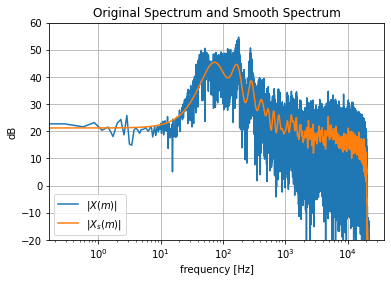

In [80]:
faxis = linspace(0,sr//2, N//2)

semilogx(faxis, 20*log10(abs(spec)[0:N//2]), label='$|X(m)|$')
semilogx(faxis, 20*log10(abs(l_spec)[0:N//2]), label='$|X_s(m)|$')
legend(loc='lower left')
title('Original Spectrum and Smooth Spectrum')
xlabel('frequency [Hz]')
ylabel('dB')
ylim([-20,60])
show()

# Liftering to remove echo

Create a delay system to test the idea:

$$y(n) = x(n) + \alpha \cdot x(n-k_1) + \beta \cdot y(n-k_2)$$

In [97]:
def delFb(x, k1, k2, alpha=0.5, beta= 0):
    y = zeros_like(x)
    y1 = 0
    for n in range(len(x)):
        y0 = x[n] + x[n-k1]*alpha + y[n-k2]*beta
        y[n] = y0
    return y 

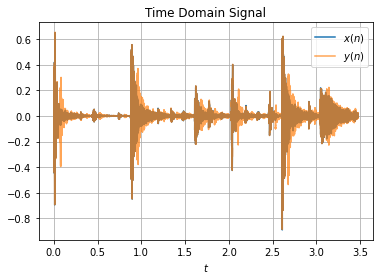

In [99]:
y = delFb(x,3000, 3000)
plot(t,x, label='$x(n)$')
plot(t,y, label='$y(n)$',alpha=0.7)

legend()
title('Time Domain Signal')
xlabel('$t$')
show()

## Check if we can recover the original Signal
We will first check if the roundtrip works, so 
- taking $y(n)$, 
- computing the complex spectrum $Y(m)$ from that, 
- computing the complex cepstrum $C_y(m)$ from that, 
- computing the complex spectrum $Y(m)$ from that, 
- and computing the time domain signal $y(n)$ from that again.

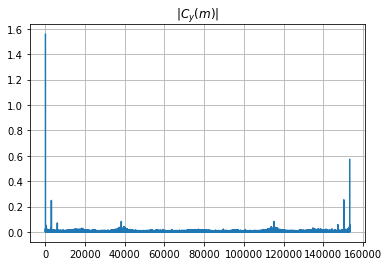

In [100]:
spec = fft.fft(y) 
ccep = fft.ifft(log(spec))
plot(abs(ccep))
_=title("$|C_y(m)|$")

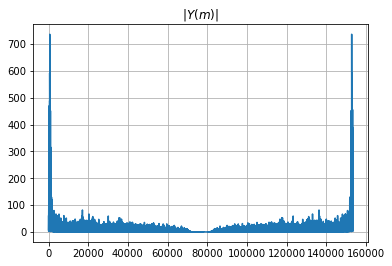

In [101]:
l_cspec = exp(fft.fft(ccep))
plot(abs(l_cspec))
_=title('$|Y(m)|$')

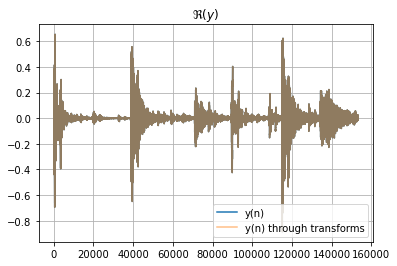

In [102]:
l_y = real(fft.ifft(l_cspec))
plot(y, label='y(n)')
plot(l_y, label='y(n) through transforms',alpha=0.5)
legend()
_=title('$\Re(y)$')

In [90]:
Audio(l_y,rate=sr)

## Liftering for echo Removal

- Look at the cepstrum $C(m)$
- find the peak corresponding to the delay of the echo
- create a window $w(m) $suppressing that peak
- multiply the cepstrum with the window to obtain a liftered cepstrum $C_l(m)$
- convert back to frequency domain, giving $X_l(m)$, and then to time domain resulting in $y_l(n)$.
- drop any imaginary residues ($\Re(y(n))$)




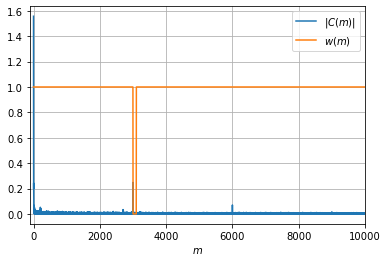

In [153]:
window = ones(N)
window[3000:3100] = 0
window[N//2:] = flip(window[0:N//2])
plot(abs(ccep), label= '$|C(m)|$')
plot(window, label= '$w(m)$')
legend()
xlim([-100,10000])
xlabel('$m$')
show()


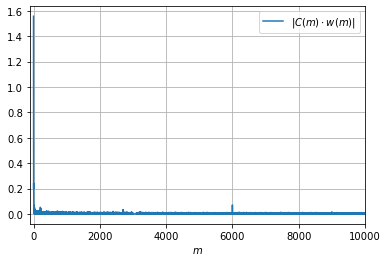

In [154]:
liftered = ccep*window
plot(abs(liftered), label= '$|C(m) \cdot w(m) |$')
legend()
xlim([-100,10000])
xlabel('$m$')
show()

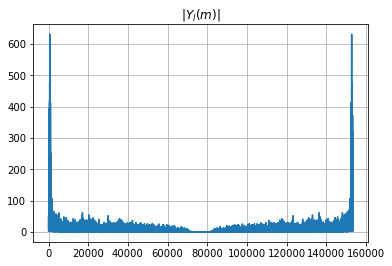

In [155]:
l_cspec = exp(fft.fft(liftered))
plot(abs(l_cspec))
_=title('$|Y_l(m)|$')

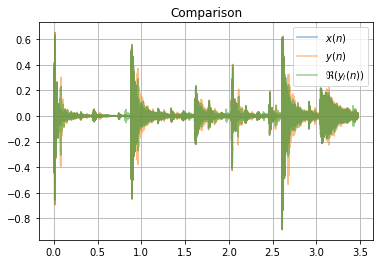

In [156]:
l_y = real(fft.ifft(l_cspec))
plot(t, x, label='$x(n)$',alpha=0.5)
plot(t, y, label='$y(n)$',alpha=0.5)
plot(t, l_y, label='$\Re(y_l(n))$',alpha=0.5)

legend()
_=title('Comparison')

# Recovered Original without echo!

In [157]:
Audio(l_y,rate=sr)

# About the FFT of the FFT
The fft of the fft idea more or less works for the magnitude cepstrum. We get a qualitatively similar result. Still there is quite a difference by a scaling factor so:

$$ |\mathscr{F}\{|X(m)|\}| \approx c \cdot |\mathscr{F}^{-1}\{log(|X(m)|)\}| $$

**But this does not work for the complex cesptrum.**


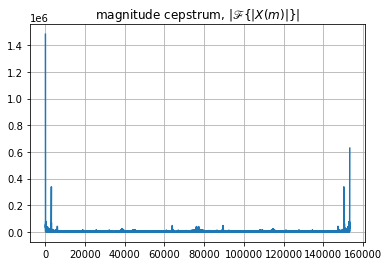

In [176]:
ccep = fft.fft(abs(spec))
plot(abs(ccep))
title("magnitude cepstrum, $|\mathscr{F}\{|X(m)|\}|$")
show()

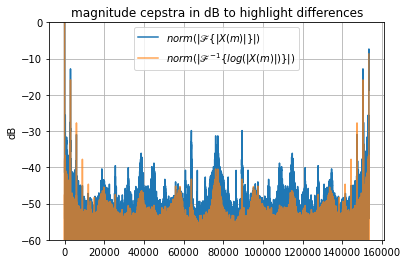

In [190]:
ccep_fft = abs(fft.fft(abs(spec)))
plot(20*log10(ccep_fft/max(ccep_fft)), label= '$norm(|\mathscr{F}\{|X(m)|\}|)$')

ccep_log = fft.ifft(log(abs(spec)))

plot(20*log10(abs(ccep_log)/max(abs(ccep_log))), label='$norm(|\mathscr{F}^{-1}\{log(|X(m)|)\}|)$',alpha=0.7)
legend()
ylabel('dB')
ylim([-60,0])
title("magnitude cepstra in dB to highlight differences")
show()

## If we are interested in the complex cepstrum
which we are if we want to lifter and transform back to the original, we run into problems. The complex cepstrum cannot be obtained via the double FFT idea:
$$ \mathscr{F}\{X(m)\} \neq \mathscr{F}^{-1}\{log(X(m))\} $$

even their absolute values do not match all all as is shown below:

$$ |\mathscr{F}\{X(m)\}| \neq |\mathscr{F}^{-1}\{log(X(m))\}| $$

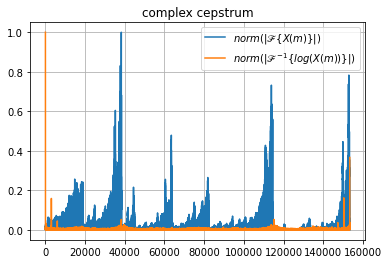

In [183]:
ccep_fft = fft.fft(spec)
plot(abs(ccep_fft)/max(abs(ccep_fft)), label= '$norm(|\mathscr{F}\{X(m)\}|)$')
ccep_log = fft.ifft(log(spec))
plot(abs(ccep_log)/max(abs(ccep_log)), label='$norm(|\mathscr{F}^{-1}\{log(X(m))\}|)$')
legend()
title("complex cepstrum")
show()